In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
def split_sample(sample, train_size, permute):
    sample_copy = sample.copy()
    size = int(train_size * len(sample_copy))
    
    if permute == True:
        np.random.seed(2)
        shuffled_indeces = np.arange(len(sample))
        np.random.shuffle(shuffled_indeces)
        indeces_train = shuffled_indeces[:size]
        indeces_test = shuffled_indeces[size:]

    elif permute == False:
        indeces_train = np.arange(len(sample))[:size]
        indeces_test = np.arange(len(sample))[size:]

    train_sample = sample_copy.iloc[indeces_train]
    test_sample = sample_copy.iloc[indeces_test]
    return train_sample, test_sample

In [3]:
def eigens_and_conidtion(X, printing='yes'):
    covXX = X.T.dot(X)
    if printing == 'yes':
        eigs_covXX = np.linalg.eig(covXX)[0]
        cond_num_covXX = max(abs(eigs_covXX)) / min(abs(eigs_covXX))
    
        print('eigenvalues: {}'.format(eigs_covXX))
        print('condition number: {}'.format(cond_num_covXX))
    return covXX

def model_coeffs(X_train, Y_train, covXX):
    return np.linalg.pinv(covXX).dot(X_train.T).dot(Y_train)

In [4]:
def x_y_splitting(data, regressors_ind, explained_var_ind):
    df = pd.DataFrame(data[regressors_ind])
    n = df.shape[0]
    X = df.copy()
    Y = pd.DataFrame(data[explained_var_ind])
    return X, Y

In [5]:
def feature_normalize(df, mu=None, sigma=None):
    df_normalized = df.copy()
    if mu is None and sigma is None:
        mu = df_normalized.mean()
        sigma = df_normalized.std(ddof=1)
    df_normalized = (df_normalized - mu) / sigma
    return df_normalized, mu, sigma

In [39]:
def predictor_filtering(train_sample, predictors, explained_var):
    lst = []
    
    for predictor in predictors:
        predictor_mean = train_sample[predictor].mean()
        explained_var_mean = train_sample[explained_var].mean()
        
        predictor_demeaned = train_sample[predictor] - predictor_mean
        explained_demeaned = train_sample[explained_var] - explained_var_mean
        
        cov_predictor_explained = np.sum(predictor_demeaned * explained_demeaned)
        predictor_variance = np.sum(np.square(predictor_demeaned))
        explained_variance = np.sum(np.square(explained_demeaned))
        
        R = cov_predictor_explained / (np.sqrt(predictor_variance * explained_variance))
        #lst.append((predictor, R))
        lst.append(R)
    corr_df = pd.DataFrame(data=lst, index=predictors, columns=[explained_var])
    display(corr_df)
    
    return corr_df

In [40]:
def pairwise_corr(train_sample, predictors):
    corr_matr = np.zeros((len(predictors), len(predictors)))
    for predictor_first in predictors:
        for predictor_second in predictors:
            predictor_first_mean = train_sample[predictor_first].mean()
            predictor_second_mean = train_sample[predictor_second].mean()
        
            predictor_first_demeaned = train_sample[predictor_first] - predictor_first_mean
            predictor_second_demeaned = train_sample[predictor_second] - predictor_second_mean
        
            cov_predictor_first_predictor_second = np.sum(predictor_first_demeaned * predictor_second_demeaned)
            predictor_first_variance = np.sum(np.square(predictor_first_demeaned))
            epredictor_second_variance = np.sum(np.square(predictor_second_demeaned))
        
            R = cov_predictor_first_predictor_second / (np.sqrt(predictor_first_variance * epredictor_second_variance))
            i = int(np.where(np.array(predictors) == predictor_first)[0])
            j = int(np.where(np.array(predictors) == predictor_second)[0])
            corr_matr[i][j] = R
    corr_data = pd.DataFrame(data=corr_matr, index=predictors, columns=predictors)
    display(corr_data)
    
    return corr_data     

In [94]:
def insert_ones(X, name="Ones"):
    X_copy = X.copy()
    n = X.shape[0]
    X_copy.insert(0, name, np.ones((n, 1)), True)
    return X_copy

In [7]:
def loss_l2(Y_hat, Y):
    Y_hat_arr, Y_arr = np.array(Y_hat), np.array(Y)
    return (np.square((Y_hat_arr - Y_arr))).mean()

In [8]:
def loss_huber(Y_hat, Y, delta=1.35):
    Y_hat_arr, Y_arr = np.array(Y_hat), np.array(Y)
    Y_abs_diff = np.abs(Y_arr - Y_hat_arr)
    return np.where(Y_abs_diff < delta, 0.5 * Y_abs_diff ** 2 , delta * (Y_abs_diff - 0.5 * delta ** 2)).mean()

In [9]:
def model_predict(X, coeffs):
    return X.dot(coeffs)

In [10]:
def gradient(X, y, coeffs, loss, delta=1.35):
    n = len(y)
    y_hat = model_predict(X, coeffs)
    if loss == 'l2':
        grad = (2 / n) * X.T.dot(y_hat - y)
    elif loss == 'huber':
        s = np.zeros((X.shape[1], 1))
        for i in range(n):
            diff = y_hat[i] - y[i]
            if np.abs(diff) <= delta:
                s += ((X[i].T) * diff).reshape(X.shape[1], 1)
            else:
                sgn = np.sign(diff)
                s += (delta * sgn[0] * (X[i].T)).reshape(X.shape[1], 1)
        grad = s / n
    return grad

In [11]:
def gradient_descent(X, y, loss, learning_rate, max_iter=100, delta=1.35):
    np.random.seed(42)
    coeffs = np.random.random(size=X.shape[1])
    coeffs = coeffs.reshape(X.shape[1], 1)
    for i in range(max_iter):
        coeffs = coeffs - learning_rate * gradient(X, y, coeffs, loss)
    return coeffs

In [12]:
def create_mini_batch(X, y, batch_size):
    batches = []
    data = np.hstack((X.copy(), y.copy()))
    np.random.shuffle(data)
    n_batches = data.shape[0] // batch_size
    
    for i in range(n_batches):
        batch = data[i * batch_size:(i + 1) * batch_size, :]
        X_batch = batch[:, :-1]
        y_batch = batch[:, -1].reshape((-1, 1))
        batches.append((X_batch, y_batch))

    if data.shape[0] % batch_size != 0:
        batch = data[i * batch_size:data.shape[0]]
        X_batch = batch[:, :-1]
        y_batch = batch[:, -1].reshape((-1, 1))
        batches.append((X_batch, y_batch))

    return batches

In [13]:
def sgd_mini_batches(X, y, loss, learning_rate, batch_size=8, alpha=0.01, t0=70, power_t=0.25,
                     eta0=0.01, max_iter=100, delta=1.35):
    np.random.seed(42)
    coeffs = np.random.random(size=X.shape[1])
    coeffs = coeffs.reshape(X.shape[1], 1)
    n = X.shape[0]
    if learning_rate == 'constant':
        func = constant
    elif learning_rate == 'invscaling':
        func = invscaling
    elif learning_rate == 'optimal':
        func = optimal
    if learning_rate != 'adaptive':
        for i in range(max_iter):
            mini_batches = create_mini_batch(X, y, batch_size)
            k = 0
            for batch in mini_batches:
                X_batch, y_batch = batch
                grad = gradient(X_batch, y_batch, coeffs, loss)
                
                t = i * max_iter + k * batch_size
                cur_lr = func(alpha, t0, t, power_t, eta0)
                coeffs = coeffs - cur_lr * grad
                k += 1
    else:
        func = adaptive
        errors_prev = []
        cur_lr = eta0
        for i in range(max_iter):
            k = 0
            errors_prev = errors_prev[-16:]
            mini_batches = create_mini_batch(X, y, batch_size)
            for batch in mini_batches:
                X_batch, y_batch = batch
                
                grad = gradient(X_batch, y_batch, coeffs, loss)
                
                t = i * max_iter + k * batch_size
                y_hat_sample = model_predict(X_sample, coeffs)
                errors_prev.append(loss_l2(y_hat_sample, y_sample))
                
                if len(errors_prev) > 15:
                    lst = errors_prev[-16:].copy()
                    if lst.index(max(lst)) == 10:
                        cur_lr = func(alpha, t0, t, power_t, eta0, cur_lr)
                if cur_lr < 1e-6:
                    break
                coeffs = coeffs - cur_lr * grad
                k += 1
                
            
    return coeffs

In [14]:
def gradient_descent_mini_batches(X, y, loss, learning_rate, batch_size=8, max_iter=100, delta=1.35):
    np.random.seed(0)
    coeffs = np.random.random(size=X.shape[1])
    coeffs = coeffs.reshape(X.shape[1], 1)
    errors = []
    for i in range(max_iter):
        mini_batches = create_mini_batch(X, y, batch_size)
        
        for batch in mini_batches:
            X_batch, y_batch = batch
            coeffs = coeffs - learning_rate * gradient(X_batch, y_batch, coeffs, loss)
            errors.append(loss_l2(model_predict(X_batch, coeffs), y_batch))

    return coeffs, errors

In [15]:
def learning_rate_schedule(base_lr, iteration, step=0.005):
    cur_lr = base_lr - iteration * step * (2 ** (iteration // 50))
    if cur_lr < step * 2:
        cur_lr = step
    return cur_lr

In [16]:
def optimal(alpha, t0, t, power_t, eta0):
    return 1 / (alpha * (t0 + t))

def invscaling(alpha, t0, t, power_t, eta0):
    return eta0 / (pow(t + 1, power_t))

def constant(alpha, t0, t, power_t, eta0):
    return eta0

def adaptive(alpha, t0, t, power_t, eta0, cur_lr):
    cur_lr = cur_lr / 5
    return cur_lr

In [17]:
def stochastic_gradient_descent(X, y, loss, learning_rate, alpha=0.01, t0=70, power_t=0.25,
                                eta0=0.01, max_iter=100, delta=1.35):
    np.random.seed(42)
    coeffs = np.random.random(size=X.shape[1])
    coeffs = coeffs.reshape(X.shape[1], 1)
    n = X.shape[0]
    if learning_rate == 'constant':
        func = constant
    elif learning_rate == 'invscaling':
        func = invscaling
    elif learning_rate == 'optimal':
        func = optimal
    if learning_rate != 'adaptive':
        for i in range(max_iter):
            indeces = np.arange(n)
            np.random.shuffle(indeces)
            for j in range(n):
                random_index = indeces[j]
                X_sample = X[random_index:random_index + 1]
                y_sample = y[random_index:random_index + 1]
                
                grad = gradient(X_sample, y_sample, coeffs, loss)
                
                t = i * max_iter + j
                cur_lr = func(alpha, t0, t, power_t, eta0)
                coeffs = coeffs - cur_lr * grad
    else:
        func = adaptive
        errors_prev = []
        cur_lr = eta0
        for i in range(max_iter):
            errors_prev = errors_prev[-16:]
            indeces = np.arange(n)
            np.random.shuffle(indeces)
            for j in range(n):
                random_index = indeces[j]
                X_sample = X[random_index:random_index + 1]
                y_sample = y[random_index:random_index + 1]
                
                grad = gradient(X_sample, y_sample, coeffs, loss)
                
                t = i * max_iter + j
                y_hat_sample = model_predict(X_sample, coeffs)
                errors_prev.append(loss_l2(y_hat_sample, y_sample))
                
                if len(errors_prev) > 15:
                    lst = errors_prev[-16:].copy()
                    if lst.index(max(lst)) == 10:
                        cur_lr = func(alpha, t0, t, power_t, eta0, cur_lr)
                if cur_lr < 1e-6:
                    break
                coeffs = coeffs - cur_lr * grad
                
            
    return coeffs

In [18]:
data = pd.read_csv('boston.csv')
train_sample, test_sample = split_sample(data, 0.9, True)

In [19]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [20]:
regressors_ind = ['age', 'rm', 'lstat']
explained_var_ind = 'medv'
    
X_train, Y_train = x_y_splitting(train_sample, regressors_ind, explained_var_ind)
X_test, Y_test = x_y_splitting(test_sample, regressors_ind, explained_var_ind)

In [21]:
X_train, mu, sigma = feature_normalize(X_train)
X_train = insert_ones(X_train)
    
covXX = eigens_and_conidtion(X_train, printing='no')
beta_OLS = model_coeffs(X_train, Y_train, covXX)
Y_hat_train = model_predict(X_train, beta_OLS)
    
X_test, _, _ = feature_normalize(X_test, mu, sigma)
X_test = insert_ones(X_test)
Y_hat_test = model_predict(X_test, beta_OLS)

In [22]:
coeffs = gradient_descent(np.array(X_train), np.array(Y_train), loss='l2', learning_rate=0.025)

In [23]:
coeffs

array([[ 2.25243441e+01],
       [-1.50909207e-02],
       [ 3.86447691e+00],
       [-4.34354549e+00]])

In [24]:
Y_hat_test_2 = model_predict(X_test, coeffs)

In [25]:
Y_hat_test_2

,0
185,21.465596
476,19.858753
449,19.110032
288,25.742328
423,14.992440
398,7.019512
462,21.829132
147,4.827528
285,26.109024
490,5.635206


In [26]:
print(loss_l2(Y_hat_test, Y_hat_test_2))

0.08930139544051689


In [27]:
coeffs_new, errors = gradient_descent_mini_batches(np.array(X_train), np.array(Y_train), loss='l2',
                                                   batch_size=28, max_iter=100, learning_rate=0.15)

In [28]:
coeffs_new

array([[23.15916997],
       [ 0.17706599],
       [ 2.89784086],
       [-5.32556055]])

In [29]:
Y_hat_test_3 = model_predict(X_test, coeffs_new)

In [30]:
Y_hat_test_3

,0
185,22.217026
476,19.570518
449,18.857490
288,26.882202
423,14.522911
398,6.520972
462,22.341018
147,5.156663
285,26.881489
490,5.734186


In [31]:
print(loss_l2(Y_hat_test_2, Y_hat_test_3))

0.9253248629624105


In [32]:
coeffs_sgd = stochastic_gradient_descent(np.array(X_train), np.array(Y_train), loss='l2',
                                         max_iter=100, learning_rate='invscaling')

In [33]:
Y_hat_test_sgd = model_predict(X_test, coeffs_sgd)

In [34]:
Y_hat_test_sgd

,0
185,21.539053
476,19.712122
449,19.014472
288,25.802995
423,14.651741
398,6.733775
462,21.935200
147,4.827478
285,25.895983
490,5.567435


In [35]:
print(loss_l2(Y_hat_test, Y_hat_test_sgd))

0.02063554971486393


In [36]:
coeffs_mini_batch_sgd = sgd_mini_batches(np.array(X_train), np.array(Y_train), loss='l2', learning_rate='invscaling', batch_size=32)
coeffs_mini_batch_sgd

array([[22.19706101],
       [-0.1336059 ],
       [ 3.93820801],
       [-4.17099556]])

In [37]:
Y_hat_test_mini_batch_sgd = model_predict(X_test, coeffs_mini_batch_sgd)
Y_hat_test_mini_batch_sgd

,0
185,21.137281
476,19.593473
449,18.833206
288,25.394426
423,14.835908
398,6.910047
462,21.477825
147,4.656362
285,25.848741
490,5.475103


In [38]:
print(loss_l2(Y_hat_test, Y_hat_test_mini_batch_sgd))

0.3166215038069921


In [127]:
import math
p = 6
def binomial_coeff(k, n):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

def create_monomials(order, X, x1, x2):
    X_copy = np.array(X.loc[:, (x1, x2)].copy())
    amount = (order + 1) * (order + 2) // 2
    indeces = X.index
    names = []
    data = np.zeros((X.shape[0], amount))
    for degree in range(order + 1):
        for x1_degree in range(degree + 1):
            data[:, degree * (degree + 1) // 2 + x1_degree] = (X_copy[:, 0] ** x1_degree) * (X_copy[:, 1] ** (degree - x1_degree))
            first_name = str(x1_degree)
            second_name = str(degree - x1_degree)
            names.append(first_name + ' , ' + second_name)
    data = pd.DataFrame(data=data, index=indeces, columns=names)
    return data

In [119]:
x1= 'age'
x2 ='rm'
X_train.loc[:, (x1, x2)]
X_train.shape[0]

455

In [120]:
dat = create_monomials(3, X_train, x1, x2)
dat

,age,rm,lstat
329,17.2,6.333,7.34
371,100.0,6.216,9.53
219,92.4,6.373,10.50
403,96.0,5.349,19.77
78,53.7,6.232,12.34
...,...,...,...
244,76.5,5.593,12.50
202,15.7,7.610,3.11
31,100.0,6.072,13.04
32,82.0,5.950,27.71


('age', 'rm')

1


,"0 , 0","0 , 1","1 , 0","0 , 2","1 , 1","2 , 0","0 , 3","1 , 2","2 , 1","3 , 0"
329,1.0,6.333,17.2,40.106889,108.9276,295.84,253.996928,689.838491,1873.55472,5088.448
371,1.0,6.216,100.0,38.638656,621.6000,10000.00,240.177886,3863.865600,62160.00000,1000000.000
219,1.0,6.373,92.4,40.615129,588.8652,8537.76,258.840217,3752.837920,54411.14448,788889.024
403,1.0,5.349,96.0,28.611801,513.5040,9216.00,153.044524,2746.732896,49296.38400,884736.000
78,1.0,6.232,53.7,38.837824,334.6584,2883.69,242.037319,2085.591149,17971.15608,154854.153
...,...,...,...,...,...,...,...,...,...,...
244,1.0,5.593,76.5,31.281649,427.8645,5852.25,174.958263,2393.046149,32731.63425,447697.125
202,1.0,7.610,15.7,57.912100,119.4770,246.49,440.711081,909.219970,1875.78890,3869.893
31,1.0,6.072,100.0,36.869184,607.2000,10000.00,223.869685,3686.918400,60720.00000,1000000.000
32,1.0,5.950,82.0,35.402500,487.9000,6724.00,210.644875,2903.005000,40007.80000,551368.000


In [121]:
d = dat.iloc[:, 1:].copy()
d = insert_ones(d, name='0, 0')
d

,"0, 0","0 , 1","1 , 0","0 , 2","1 , 1","2 , 0","0 , 3","1 , 2","2 , 1","3 , 0"
329,1.0,6.333,17.2,40.106889,108.9276,295.84,253.996928,689.838491,1873.55472,5088.448
371,1.0,6.216,100.0,38.638656,621.6000,10000.00,240.177886,3863.865600,62160.00000,1000000.000
219,1.0,6.373,92.4,40.615129,588.8652,8537.76,258.840217,3752.837920,54411.14448,788889.024
403,1.0,5.349,96.0,28.611801,513.5040,9216.00,153.044524,2746.732896,49296.38400,884736.000
78,1.0,6.232,53.7,38.837824,334.6584,2883.69,242.037319,2085.591149,17971.15608,154854.153
...,...,...,...,...,...,...,...,...,...,...
244,1.0,5.593,76.5,31.281649,427.8645,5852.25,174.958263,2393.046149,32731.63425,447697.125
202,1.0,7.610,15.7,57.912100,119.4770,246.49,440.711081,909.219970,1875.78890,3869.893
31,1.0,6.072,100.0,36.869184,607.2000,10000.00,223.869685,3686.918400,60720.00000,1000000.000
32,1.0,5.950,82.0,35.402500,487.9000,6724.00,210.644875,2903.005000,40007.80000,551368.000


In [139]:
def create_polynomial_model(order, X_train, Y_train, x1, x2, change=True, betas=None, mu=None, sigma=None):
    V_train = create_monomials(order, X_train, x1, x2)
    V_train, mu, sigma = feature_normalize(V_train.iloc[:, 1:], mu, sigma)
    V_train = insert_ones(V_train, name='0, 0')
    
    covXX = eigens_and_conidtion(V_train, printing='no')
    if change == True:
        beta_OLS = model_coeffs(V_train, Y_train, covXX)
        Y_hat_train = model_predict(V_train, beta_OLS)
    
        return Y_hat_train, beta_OLS, mu, sigma
    else:
        Y_hat_train = model_predict(V_train, betas)
        return Y_hat_train, betas, mu, sigma

In [146]:
data = pd.read_csv('boston.csv')
train_sample, test_sample = split_sample(data, 0.8, True)

regressors_ind = ['lstat', 'nox']
explained_var_ind = 'medv'
    
X_train, Y_train = x_y_splitting(train_sample, regressors_ind, explained_var_ind)
X_test, Y_test = x_y_splitting(test_sample, regressors_ind, explained_var_ind)

x1= 'lstat'
x2 ='nox'

In [153]:
p = 7
n_train = X_train.shape[0]

#k = (p + 2)* (p + 1) // 2
MSE_train_fold = np.zeros((p, n_train))
CV_MSE_fold = np.zeros((p, n_train))
MSE_train = np.zeros((p, 1))
MSE_test = np.zeros((p, 1))
MSE_gen = np.zeros((p, 1))
CV_MSE = np.zeros((p, 1))

indeces = np.array(X_train.index.copy())
for order in range(p):
    for iteration in range(n_train):
        
        X_train_copy = X_train.copy()
        Y_train_copy = Y_train.copy()
            
        X_fold = X_train_copy.iloc[iteration:iteration + 1]
        Y_fold = Y_train_copy.iloc[iteration:iteration + 1]
            
        X_train_fold = X_train_copy.drop(indeces[iteration])
        Y_train_fold = Y_train_copy.drop(indeces[iteration])
        #X_fold = X_train[iteration: iteration + 1]
        #Y_fold = Y_train[iteration: iteration + 1]
        #X_train_fold = X_train[np.r_[0:iteration, iteration + 1:n_train]]
        #Y_train_fold = Y_train[np.r_[0:iteration, iteration + 1:n_train]]
        
        Y_hat_train_fold, beta_train_fold, mu_fold, sigma_fold = create_polynomial_model(order, X_train_fold, Y_train_fold, x1, x2)
        MSE_train_fold[order, iteration] = loss_l2(Y_hat_train_fold, Y_train_fold)
        Y_hat_fold, _, _, _ = create_polynomial_model(order, X_fold, Y_fold, x1, x2, False, beta_train_fold, mu_fold, sigma_fold)
        CV_MSE_fold[order, iteration] = loss_l2(Y_hat_fold, Y_fold)
        
    CV_MSE[order] = CV_MSE_fold[order, :].mean()
    MSE_train[order] = MSE_train_fold[order, :].mean()
    
    Y_hat_train, beta_train, mu, sigma = create_polynomial_model(order, X_train, Y_train, x1, x2)
    Y_hat_test, _, _, _ = create_polynomial_model(order, X_test, Y_test, x1, x2, False, beta_train, mu, sigma)
    MSE_test[order] = loss_l2(Y_hat_test, Y_test)

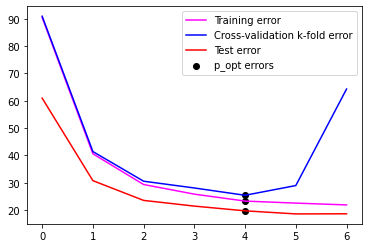

In [155]:
p_opt = 4
dots = [MSE_train[p_opt], CV_MSE[p_opt], MSE_test[p_opt]]


plt.plot(MSE_train, color='magenta')
plt.plot(CV_MSE, color='blue')
plt.plot(MSE_test, color='red')
plt.scatter([p_opt for _ in range(3)], dots, color='black')
plt.legend(('Training error', 'Cross-validation k-fold error', 'Test error', 'p_opt errors'))
plt.show()